In [1]:
import os
os.environ["R_HOME"] = "C:/Users/Ian/anaconda3/envs/gpr/Lib/R"
os.environ["PATH"]   = "C:/Users/Ian/anaconda3/envs/gpr/Lib/R/bin/x64" + ";" + os.environ["PATH"]
from advanced_pca import CustomPCA

import matplotlib.pyplot as plt
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import FactorAnalysis
import pandas as pd
from sklearn.model_selection import KFold 
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo

#os.environ["R_HOME"] = "C:/Program Files/R/R-4.2.1"


Unable to determine R library path: Command '('C:/Users/Ian/anaconda3/envs/gpr/Lib/R\\bin\\Rscript', '-e', 'cat(Sys.getenv("LD_LIBRARY_PATH"))')' returned non-zero exit status 1.


In [3]:
data=pd.read_csv('taskdata2.csv') # Reading datafile (should be in the same directory as our IDE)
PCAdata = data.drop(["Participant #","Runtime_mod","Task_name","Gradient 1","Gradient 2","Gradient 3"],axis=1) # Getting rid of unneeded columns for PCA

In [5]:
chi_square_value,p_value=calculate_bartlett_sphericity(PCAdata) # I belive this checks for correlations within our dataset which would make a PCA weird
chi_square_value, p_value # significant p-value means we're ok

(1530.0281592501617, 7.209195086590712e-260)

In [6]:
kmo_all,kmo_model=calculate_kmo(PCAdata) # Not even going to pretend I understand the Kaiser-Meyer-Olkin criteria
kmo_all,kmo_model # kmo_model > 0.6 is acceptable

(array([0.63298588, 0.64604436, 0.57284147, 0.4294407 , 0.69657783,
        0.72366306, 0.7442439 , 0.76862309, 0.78624435, 0.7283743 ,
        0.67430926, 0.73802563, 0.69320789, 0.7289108 ]),
 0.7053256179287692)

In [7]:
PCAmodel = CustomPCA(n_components=4,rotation='varimax') 
PCAmodel.fit(PCAdata)
loadings = PCAmodel.components_.T
names = PCAdata.columns
loadings = pd.DataFrame(loadings,index=names)
PCAresults = PCAmodel.transform(PCAdata).T

In [8]:
FAC=np.asarray([PCAresults[0], PCAresults[1],PCAresults[2],PCAresults[3]]).T
GRAD=np.asarray([data["Gradient 1"], data["Gradient 2"],data["Gradient 3"]]).T
KeepIndex=~np.isnan(FAC[:,0])
tasknum = len(data["Task_name"].unique())

In [9]:

Tasklabels,Taskindices=np.unique(data["Task_name"],return_inverse=True)
FAC_TaskCentres=np.zeros([tasknum,4])
for i in range(tasknum):
    FAC_TaskCentres[i,:]=FAC[Taskindices==i,:].mean(axis=0)

Grad_TaskCentres=np.zeros([tasknum,3])
for i in range(tasknum):

    Grad_TaskCentres[i,:]=GRAD[np.ix_(Taskindices==(i),[0,1,2])].mean(axis=0)


In [10]:
#Fit whole dataset



fig_estimated_mean = make_subplots(rows=2, cols=2, subplot_titles=("Component 1", "Component 2", "Component 3", "Component 4"),specs=[[{'type': 'surface'}, {'type': 'surface'}],[{'type': 'surface'}, {'type': 'surface'}]])

fig_standard_deviation = make_subplots(rows=2,cols=2, subplot_titles=("Component 1", "Component 2", "Component 3", "Component 4"),specs=[[{'type': 'surface'}, {'type': 'surface'}],[{'type': 'surface'}, {'type': 'surface'}]])

count = 0

for i in range(2):
    for j in range(2):

        standardscaler=StandardScaler()
        X=Grad_TaskCentres

        y = standardscaler.fit_transform(FAC_TaskCentres[:,count].reshape(-1,1))    


        kernel = 1.0 * Matern(length_scale=0.5, length_scale_bounds=(0.5, 1), nu=2.5) + WhiteKernel(noise_level_bounds=[0.001,0.1],noise_level=0.05)


        gpr = GaussianProcessRegressor(kernel=kernel, random_state=3,normalize_y=False,alpha=0)
        
        @ignore_warnings(category=ConvergenceWarning)
        def _f():
            gpr.fit(X, y)

        _f()


        lim = 0.6
        res = 50
        lin = np.linspace(-lim, lim, res)

        
        x1, x2, x3 = np.meshgrid(lin, lin, lin)

        xx = np.vstack((x1.flatten(), x2.flatten(), x3.flatten())).T

        y_mean, y_sd = gpr.predict(xx, return_std=True)


        fig_estimated_mean.add_trace(go.Volume(
            x=pd.Series(x1.flatten(),name="Gradient 1"),
            y=pd.Series(x2.flatten(),name="Gradient 2"),
            z=pd.Series(x3.flatten(),name="Gradient 3"),
            value=y_mean,
            hoverinfo='skip',
            opacityscale=[[0, 0.8], [0.35, 0],[0.65, 0], [1, 0.8]],
            surface_count=25,
            showlegend=False,
            colorbar={"tickmode":"array",'tickvals': [min(y_mean),max(y_mean)],'ticktext': ["Predicted low loading","Predicted high loading"]}

            ),i+1,j+1)

        fig_estimated_mean.add_trace(go.Scatter3d(
            x=Grad_TaskCentres[:,0], 
            y=Grad_TaskCentres[:,1],
            z=Grad_TaskCentres[:,2],
            marker_color=FAC_TaskCentres[:,count],
            text=Tasklabels,mode="markers+text",
            showlegend=False,
            ),i+1,j+1)

       

        fig_standard_deviation.add_trace(go.Volume(
            x=pd.Series(x1.flatten(),name="Gradient 1"),
            y=pd.Series(x2.flatten(),name="Gradient 2"),
            z=pd.Series(x3.flatten(),name="Gradient 3"),
            value=y_sd,
            hoverinfo='skip',
            showlegend=False,
            #showscale=False,
            opacityscale=[[0, 0.8], [0.35, 0],[0.65, 0], [1, 0.8]],
            colorbar={"tickmode":"array",'tickvals': [min(y_sd),max(y_sd)],'ticktext': ["Low uncertainty in predicted loading","High uncertainty in predicted loading"]},
            surface_count=25,
            ),i+1,j+1)
        count += 1
        fig_estimated_mean.update(layout_coloraxis_showscale=False)
        
fig_estimated_mean.write_html("estimated_mean.html")
fig_standard_deviation.write_html("standard_deviation.html")

In [11]:
# Do in 3 gradient dimensions
Tasklabels,Taskindices=np.unique(data.Task_name,return_inverse=True)
FAC_TaskCentres=np.zeros([tasknum,4])
for i in range(tasknum):
    FAC_TaskCentres[i,:]=FAC[Taskindices==i,:].mean(axis=0)

Grad_TaskCentres=np.zeros([tasknum,3])
for i in range(tasknum):
    #Grad_TaskCentres[i,:]=GRAD[Taskindices==i+1,(0,2)].mean(axis=0)
    Grad_TaskCentres[i,:]=GRAD[np.ix_(Taskindices==(i),[0,1,2])].mean(axis=0)


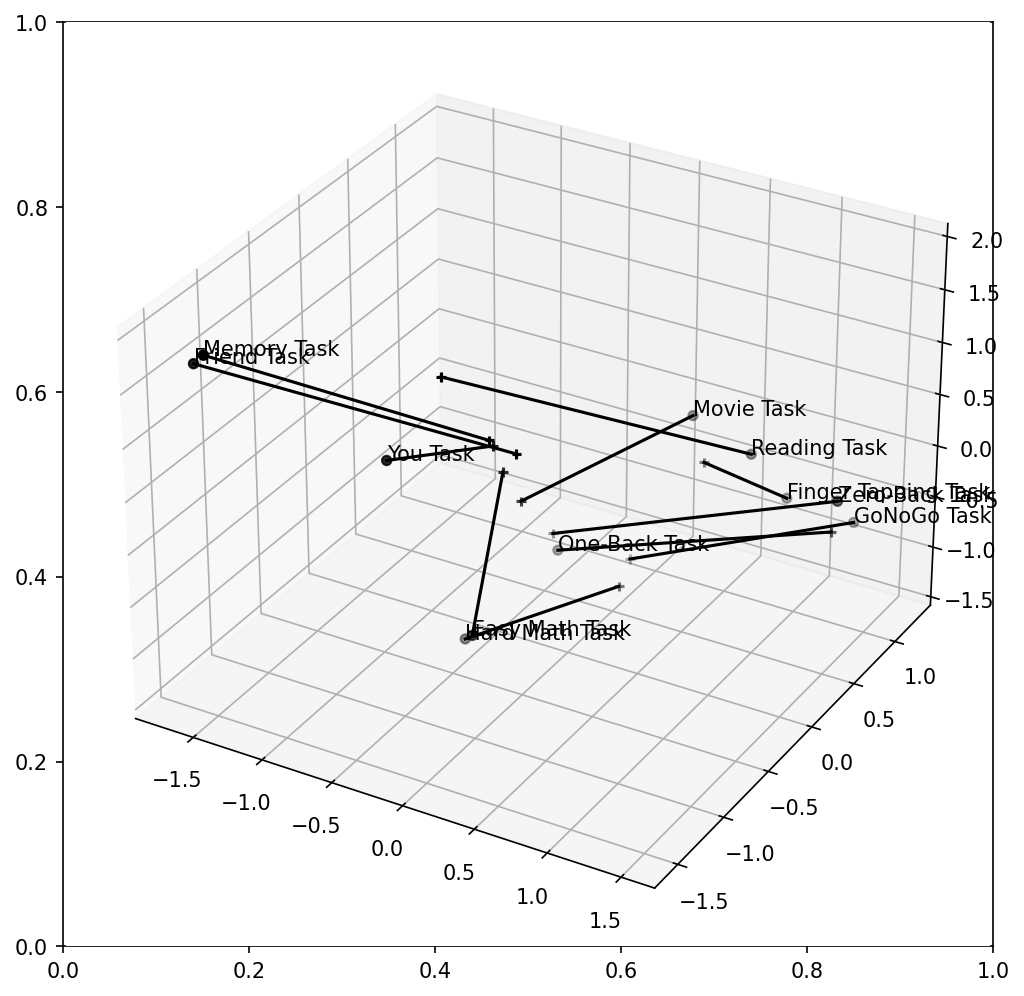

In [12]:


#Assess out of sample prediction with 3d gradient

fig, axs = plt.subplots(1,1,figsize=(8, 8), dpi=150)

k = tasknum
kf = KFold(n_splits=k, random_state=None)
numFac=4

X=Grad_TaskCentres
standardscaler=StandardScaler()
avg_acc_score=np.zeros([numFac])
pred_Fac=np.zeros([tasknum,numFac])
real_Fac=np.zeros([tasknum,numFac])

for i in range(numFac):
    acc_score = []
    y = standardscaler.fit_transform(FAC_TaskCentres[:,i].reshape(-1,1))    

    for train_index , test_index in kf.split(X):

        X_train , X_test = X[train_index,:],X[test_index,:]
        y_train , y_test = y[train_index] , y[test_index]

        kernel = 1.0 * Matern(length_scale=0.5, length_scale_bounds=(0.5, 1), nu=2.5)+ WhiteKernel(noise_level_bounds=[0.001,0.5],noise_level=0.05)
        gpr = GaussianProcessRegressor(kernel=kernel, random_state=3,normalize_y=False,alpha=0.0)
        
        @ignore_warnings(category=ConvergenceWarning)
        def __f():
            gpr.fit(X_train, y_train)
        __f()
        
        pred_values = gpr.predict(X_test)
        pred_Fac[test_index,i]=pred_values
        real_Fac[test_index,i]=y_test
        acc=np.abs(pred_values-y_test.T).sum()
        acc_score.append(acc)
        
    avg_acc_score[i] = np.median(acc_score)

ax = fig.add_subplot(1, 1, 1, projection='3d')

ax.scatter(pred_Fac[:,0],pred_Fac[:,1],pred_Fac[:,2],c='k',marker='+')
ax.scatter(real_Fac[:,0],real_Fac[:,1],real_Fac[:,2],c='k',marker='o')

for i in range(tasknum):
    ax.plot([pred_Fac[i,0],real_Fac[i,0]],[pred_Fac[i,1],real_Fac[i,1]],[pred_Fac[i,2],real_Fac[i,2]],c='k',marker='')
    ax.text(real_Fac[i,0],real_Fac[i,1],real_Fac[i,2],Tasklabels[i],c='k')
    

In [13]:
np.power(np.power(pred_Fac-real_Fac,2).mean(axis=1),0.5)

array([0.74927839, 0.39306773, 1.06058278, 0.69323249, 0.65822375,
       1.49069139, 0.81581767, 0.93745853, 1.20585884, 1.0106669 ,
       0.95019673])

In [14]:
avg_acc_score

array([1.12452699, 0.60297432, 0.62083427, 0.58431207])

In [15]:

Tasklabels,Taskindices=np.unique(data.Task_name,return_inverse=True)
FAC_TaskCentres=np.zeros([tasknum,4])
for i in range(tasknum):
    FAC_TaskCentres[i,:]=FAC[Taskindices==i,:].mean(axis=0)

Grad_TaskCentres=np.zeros([tasknum,3])
for i in range(tasknum):
    Grad_TaskCentres[i,:]=GRAD[Taskindices==i,:].mean(axis=0)


In [16]:
from sklearn.model_selection import permutation_test_score

k = 4
kernel = 1.0 * Matern(length_scale=0.5, length_scale_bounds=(0.5, 1), nu=2.5) 
kf = KFold(n_splits=k, random_state=None)



gpr = GaussianProcessRegressor(kernel=kernel, random_state=None,normalize_y=True,alpha=0.1)
X=Grad_TaskCentres
scores = {}

for PCnum in range(FAC_TaskCentres.shape[1]):
    standardscaler=StandardScaler()

    y = FAC_TaskCentres[:,PCnum]
    
    @ignore_warnings(category=ConvergenceWarning)
    def ___f():
        score_gradfac, perm_scores_gradfac, pvalue_gradfac = permutation_test_score(gpr, X, y, scoring="neg_mean_absolute_error", cv=kf, n_permutations=1000)
    
        scores.update({PCnum:[score_gradfac,pvalue_gradfac]})
    
    ___f()




In [17]:
numloadings = 5
for score in scores:
    loading = loadings[score]
    loadingpos = loading.apply(lambda x: np.abs(x)).sort_values(ascending=False)
    tops = loading[loadingpos[:numloadings].index]
    print(
        """
        Results for component {}:
        Largest loadings: 
        """.format(score)
        )
    with pd.option_context('display.max_rows', 5,
                       'display.max_columns', None,
                       'display.width', 1000,
                       'display.precision', 3,
                       'display.colheader_justify', 'center'):
        display(tops)
    print(
        """
        Permutation test score: {},
        Permutation test significance: {}
        """.format(scores[score][0],scores[score][1])
        )



        Results for component 0:
        Largest loadings: 
        


Distracting_response    0.518
Future_response         0.484
Focus_response          0.380
Intrusive_response      0.332
Self_response           0.284
Name: 0, dtype: float64


        Permutation test score: -0.8752787585243698,
        Permutation test significance: 0.14485514485514486
        

        Results for component 1:
        Largest loadings: 
        


Detailed_response     -0.501
Deliberate_response   -0.479
Knowledge_response    -0.406
Absorption_response   -0.340
Past_response         -0.313
Name: 1, dtype: float64


        Permutation test score: -1.3497513605038631,
        Permutation test significance: 0.061938061938061936
        

        Results for component 2:
        Largest loadings: 
        


Other_response        0.561
Past_response         0.500
Problem_response     -0.452
Self_response         0.354
Knowledge_response    0.226
Name: 2, dtype: float64


        Permutation test score: -1.3934231030267308,
        Permutation test significance: 0.015984015984015984
        

        Results for component 3:
        Largest loadings: 
        


Modality_response       0.917
Other_response         -0.203
Distracting_response    0.184
Self_response           0.163
Focus_response         -0.161
Name: 3, dtype: float64


        Permutation test score: -0.8700535579448904,
        Permutation test significance: 0.13986013986013987
        
